# Mejoras

POR HACER
* implementar bucle o funcion para leer el conjunto test y obtener la matriz de confusion (lo mas importante por ahora) --> ERROR
* refactorizar codigo
* revisar codigo alternativa 1 y 2


HECHOS
* crear modelo cambiando la ultima capa y congelar capas a partir de la ultima convolucional
* cargar pesos
* compilar
* muestras train, val y test


Comentarios:

* parametros a tunear
    
    * input de 150x150 mejora mucho frente a 224x224 (aunque se use bicubic o lanzcos)
    * numero de capas y  cantidad 256 // 1024 // 2048 // 4096
    * loss functions https://keras.io/losses/
    * softmax (algunos autores incluso en multiclass usan sigmoid ¿?)
    * optimizer rmsprop (creo q es el apropiado) vs SGD con lr 0.01 y 0.001
    
mejores resultados con softmax (que creo que son los adecuados)

1.- 1 capa dense de 256 sgd con lr 0.001 --> 86.70% con loss 0.3859 --> ELEGIDA ENTRE TODAS LAS ARQUITECTURAS, en dfmap lr = 0.01

2.- 1 capa dense de 256 rmsprop --> 89.1% con loss 0.8582

3.- 2 capa dense de 1024 rmsprop --> 87.80% con loss 1.1068

4.- 1 capa dense de 1024 rmsprop --> 89.70% con loss 1.0047

ref

http://www.codesofinterest.com/2017/08/bottleneck-features-multi-class-classification-keras.html

In [1]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np
import math
# import os
# import cv2

Using TensorFlow backend.


In [1]:
img_width = 150
img_height = 150

epochs = 50
batch_size = 16

train_data_dir = "train"  
validation_data_dir = "validation"
test_data_dir = "test"

In [3]:
import time

ti_bn_features = time.time()

model = applications.VGG16(include_top=False, weights='imagenet')

datagen = ImageDataGenerator(rescale=1. / 255)

'''
https://github.com/keras-team/keras/blob/master/keras/preprocessing/image.py#L1002
if PIL version 1.1.3 interpolation = 'lanczos'
else interpolation = 'bicubic' 
''' 

generator = datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = None,
    shuffle = False,
    interpolation = 'lanczos')



nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 

bnfeatures_train = model.predict_generator(
    generator, predict_size_train)

np.save('../data/output_convnet/bnfeatures_train.npy', bnfeatures_train)


generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
    interpolation = 'lanczos')

nb_validation_samples = len(generator.filenames)
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bnfeatures_val = model.predict_generator(  
     generator, predict_size_validation)

np.save('../data/output_convnet/bnfeatures_val.npy', bnfeatures_val)

        
tf_bn_features = time.time()    
tt_bn_features = tf_bn_features - ti_bn_features
print(time.strftime("%H:%M:%S", time.gmtime(tt_bn_features)))

Found 3000 images belonging to 8 classes.
Found 1000 images belonging to 8 classes.
00:00:33


In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/DirectoryIterator
# print(type(generator)) # type class
# print(len(generator.filenames)) # number of imgs in train folder
# print(generator.class_indices) # categories
# print(len(generator.class_indices)) # number of categories

Found 3000 images belonging to 8 classes.
Found 1000 images belonging to 8 classes.
Train on 3000 samples, validate on 1000 samples
Epoch 1/50
3000/3000 [==============================] - 1s 452us/step - loss: 1.6501 - acc: 0.4013 - val_loss: 1.3138 - val_acc: 0.5730
Epoch 2/50
3000/3000 [==============================] - 1s 324us/step - loss: 1.2331 - acc: 0.5800 - val_loss: 1.0359 - val_acc: 0.7120
Epoch 3/50
3000/3000 [==============================] - 1s 356us/step - loss: 1.0695 - acc: 0.6410 - val_loss: 0.9357 - val_acc: 0.7040
Epoch 4/50
3000/3000 [==============================] - 1s 285us/step - loss: 0.9394 - acc: 0.6883 - val_loss: 0.8418 - val_acc: 0.7530
Epoch 5/50
3000/3000 [==============================] - 1s 328us/step - loss: 0.8857 - acc: 0.7063 - val_loss: 0.7563 - val_acc: 0.7860
Epoch 6/50
3000/3000 [==============================] - 1s 366us/step - loss: 0.8113 - acc: 0.7433 - val_loss: 0.7316 - val_acc: 0.7710
Epoch 7/50
3000/3000 [==============================

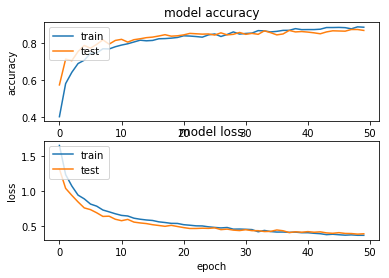

00:00:53


In [5]:
ti_bn_train = time.time()

datagen_top = ImageDataGenerator(rescale=1./255)  

generator_top = datagen_top.flow_from_directory(
    train_data_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode='categorical',  
    shuffle=False,
    interpolation = 'lanczos')  

nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  

# load the bottleneck features saved earlier  
train_data = np.load('../data/output_convnet/bnfeatures_train.npy')  

# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  

# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)



generator_top = datagen_top.flow_from_directory(  
    validation_data_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode=None,  
    shuffle=False,
    interpolation = 'lanczos')  

nb_validation_samples = len(generator_top.filenames)  

validation_data = np.load('../data/output_convnet/bnfeatures_val.npy')  

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)


# top model
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes, activation='softmax'))  

learning_rate = 0.001

model.compile(optimizer=SGD(lr=learning_rate),
              loss='categorical_crossentropy', metrics=['accuracy']) 

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels))  

model.save_weights('../data/output_convnet/bn_VGG16_model.h5')  

(eval_loss, eval_accuracy) = model.evaluate(
    validation_data, validation_labels, batch_size=batch_size, verbose=1)

print()
print()
print("acc: {:.2f}%".format(eval_accuracy * 100))  
print("loss: {}".format(eval_loss))

plt.figure(1)  
   
# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

tf_bn_train = time.time()    
tt_bn_train = tf_bn_train - ti_bn_train
print(time.strftime("%H:%M:%S", time.gmtime(tt_bn_train)))

In [15]:
import os

# listado del train
img_test_real = []
img_cat_real = [] # conf mat
img_cat_pred = [] # conf mat

img_folder = sorted([folder for folder in os.listdir(test_data_dir)
                  if os.path.isdir(os.path.join(test_data_dir, folder))])

for index_folder, category in enumerate(img_folder):
    
    folder = os.path.join(test_data_dir, category)

    for index_img, img in enumerate(os.listdir(folder)):
        
        if img.endswith(".tif"): # just in case there are other kind of files like .db
            img_test_real.append(os.path.join(folder, img))
            img_cat_real.append(img_folder[index_folder])

    print("Category {0:s} has {1:d} images.".format(category, index_img+1))

In [37]:
import numpy as np
import time
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
# from keras import backend as K


class_dictionary = np.load("../data/output_convnet/class_indices.npy").item()
num_classes = len(class_dictionary)

image_path = "test/"


# init time
ti_pred = time.time()

for index, img in enumerate(img_test_real):
    
    if not index % 100:
        print("image {0:d} processed".format(index))
    
    # pre process
    img = image.load_img(img, target_size=(224, 224), interpolation='lanczos')
    x = image.img_to_array(img)
    
#     x = x / 255
    
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    
    model = VGG16(include_top=False, weights='imagenet')
    bn_prediction = model.predict(x)
    
    model = Sequential()
    model.add(Flatten(input_shape=bn_prediction.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))
    
    model.load_weights("../data/output_convnet/bn_VGG16_model.h5") 

    class_predicted = model.predict_classes(bn_prediction)

    inID = class_predicted[0]  
   
    class_dictionary = generator_top.class_indices  
   
    inv_map = {v: k for k, v in class_dictionary.items()}  
   
    label = inv_map[inID] 
    
    img_cat_pred.append(label)
    
# stop time
tf_pred = time.time()    
tt_pred = tf_pred - ti_pred
print(time.strftime("%H:%M:%S", time.gmtime(tt_pred)))  

image 0 processed


ValueError: Dimension 0 in both shapes must be equal, but are 25088 and 8192 for 'Assign_131' (op: 'Assign') with input shapes: [25088,256], [8192,256].

In [ ]:
import cv2
predict()